In [ ]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *
device = torch.device('cpu')


import numpy as np
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

np.random.seed(42)


read data

In [ ]:
df_bsl_read=generate_bsl()
df_bsl_read.dropna(inplace=True)
df_outcome=generate_outcome()
df_outcome

df_Y_read = df_outcome[['USUBJID'] + [f'Y{i}' for i in range(1, 11)]]
df_I = df_outcome[['USUBJID'] + [f'I{i}' for i in range(1, 11)]]
df_D = df_outcome[['USUBJID'] + [f'D{i}' for i in range(1, 11)]]
df_egfr, df_hba1c, df_bmi = generate_longi_cov()
df_Y_read

,USUBJID,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
1,EX2211-3748/5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EX2211-3748/16,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EX2211-3748/62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9337,EX2211-3748/99921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9338,EX2211-3748/99929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9339,EX2211-3748/99971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ones_count = (df_Y_read.drop(columns=['USUBJID']) == 1).sum().sum()
ones_count

1302

In [6]:
df_hba1c

,USUBJID,0,12,18,24,3,30,36,42,48,54,6,60,1,61
1,EX2211-3748/10012,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,NaN,NaN
2,EX2211-3748/10023,7.6,6.0,6.3,6.0,6.3,6.1,6.4,6.8,6.5,6.5,6.3,7.3,NaN,NaN
3,EX2211-3748/10028,9.9,9.5,7.9,9.6,8.4,9.2,9.9,9.6,9.6,9.6,8.6,9.6,NaN,NaN
4,EX2211-3748/10034,9.6,9.6,9.5,9.3,9.6,7.0,6.0,6.0,6.0,6.0,10.9,6.3,NaN,NaN
5,EX2211-3748/10050,7.5,7.8,8.9,8.7,8.0,8.5,8.1,8.1,8.1,8.1,6.3,9.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,7.1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN
9337,EX2211-3748/99921,8.6,6.5,6.6,6.6,6.0,6.5,7.0,7.0,7.0,7.0,6.1,6.3,NaN,NaN
9338,EX2211-3748/99929,7.3,7.0,7.0,7.0,6.9,7.0,7.0,7.0,7.0,7.0,6.9,7.0,NaN,NaN
9339,EX2211-3748/99971,10.5,8.3,10.0,11.1,9.8,10.0,9.4,9.7,9.7,9.7,9.7,10.7,8.9,NaN


In [7]:
df_bmi

,USUBJID,0,12,24,36,48,6,60
1,EX2211-3748/10012,31.6,31.6,31.6,31.6,31.6,31.6,31.6
2,EX2211-3748/10023,39.0,37.3,37.3,38.2,39.5,38.5,39.9
3,EX2211-3748/10028,30.8,30.7,30.4,29.3,29.3,30.6,30.1
4,EX2211-3748/10034,41.4,42.6,41.7,30.4,30.4,41.9,29.5
5,EX2211-3748/10050,50.8,48.8,45.8,45.2,45.2,45.1,44.7
...,...,...,...,...,...,...,...,...
9327,EX2211-3748/99915,37.5,37.5,37.5,37.5,37.5,37.5,37.5
9328,EX2211-3748/99921,33.7,31.4,33.3,33.4,33.4,31.1,33.1
9329,EX2211-3748/99929,27.0,27.8,27.8,27.8,27.8,28.4,27.8
9330,EX2211-3748/99971,28.0,31.3,29.9,29.7,29.7,29.7,29.6


In [8]:
df_egfr

,USUBJID,0,12,24,36,48,6,60,61,30,42,1,18,3,54
1,EX2211-3748/10012,96.7,96.7,96.7,96.7,96.7,96.7,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX2211-3748/10023,84.3,89.5,91.2,86.8,84.3,91.2,84.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX2211-3748/10028,84.4,77.1,70.0,88.5,88.5,78.3,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/10034,75.5,91.0,83.3,78.0,78.0,79.2,92.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EX2211-3748/10050,75.7,90.0,59.0,42.3,42.3,100.6,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,79.8,79.8,79.8,79.8,79.8,79.8,79.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9337,EX2211-3748/99921,93.1,94.2,93.6,81.4,81.4,96.9,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9338,EX2211-3748/99929,105.1,107.0,107.0,107.0,107.0,93.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9339,EX2211-3748/99971,103.4,90.7,91.2,95.0,95.0,85.2,90.7,NaN,NaN,NaN,95.6,NaN,NaN,NaN


The longitudinal features are processed with these rules:
1. As hba1c has been measured several times, we use it as the benchmark for marking the records. However, we still discard month = 1 and month = 61 as there are not that many
2. Since egfr and bmi are measured less frequently, we impute the missing values using the observations in the previous visit time.
3. The simulated data will be evaluated by masking up intervals that the egfr and bmi are not recorded.

Also, we standardize continuous variables in baseline covariates and time varying covariates.

In [151]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
df_bsl.drop(df_bsl[(df_bsl['TRIG1BL'] > 8) | (df_bsl['CREATBL'] > 160)].index, inplace=True)



# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# ----------------- Time Points You Care About ---------------------
# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)


for D in (df_Y, df_z1_clean, df_z2_clean, df_z3_clean, df_bsl):
    D.sort_values('USUBJID', inplace=True)
    D.reset_index(drop=True, inplace=True)

cols = [str(tp) for tp in time_points]

for df in (df_z1_clean, df_z2_clean, df_z3_clean):
    # compute per-column mean & std, skipping NaNs
    means = df[cols].mean(skipna=True)
    stds  = df[cols].std(skipna=True)

    # subtract mean, divide by std; NaNs remain NaN
    df[cols] = (df[cols] - means) / stds

# ----------------- Build the Z torch tensor (longitudinal) ----------------------

Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values

    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',"HBA1CBL","BMIBL", 'SMOKER_CURRENT.SMOKER',
    "STROKEFL",	
     'KIDFL',
      'MIFL',	
    # "STENFL",
    # #"AGE", 
    # "DIABDUR",
    #"HDL1BL",	"LDL1BL",	
    # "CHOL1BL",	
    #"TRIG1BL", 
    # "CREATBL"
    ])

binary_cols     = ['SEX_F', 'SMOKER_NEVER.SMOKED',"STENFL",'NEPSCRFL'] 
continuous_cols = [c for c in df_bsl_features.columns
                   if c not in binary_cols]

# 2. Scale the continuous ones to zero‑mean, unit‑variance
scaler = StandardScaler()
df_bsl_cont = pd.DataFrame(
    scaler.fit_transform(df_bsl[continuous_cols]),
    columns=continuous_cols,
    index=df_bsl.index
)

df_bsl_norm = pd.concat([df_bsl_features[binary_cols],df_bsl_cont], axis=1)

df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)
s_tensor = torch.tensor(df_bsl_norm.astype(float).values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values))
print(np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([8730, 11])
z_tensor shape: torch.Size([8730, 33])
x_tensor shape (ARM): torch.Size([8730, 11])
y_tensor shape: torch.Size([8730, 11])
True
True
tensor(False)
Total number of 1s in df_Y: 1168


In [10]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=20, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=4)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=15000, lr=1e-3, print_every_iter=1000)

number of covariates: 11
Epoch 1: loss 2.6232, loss1 2.7550, loss2 0.2636
Epoch 1000: loss 1.9240, loss1 3.8296, loss2 3.8112
Epoch 2000: loss 1.9410, loss1 3.8532, loss2 3.8245
Epoch 3000: loss 1.9292, loss1 3.8522, loss2 3.8461
Epoch 4000: loss 1.9304, loss1 3.8486, loss2 3.8363
Epoch 5000: loss 1.9274, loss1 3.8717, loss2 3.8886
Epoch 6000: loss 1.9296, loss1 3.8650, loss2 3.8709
Epoch 7000: loss 1.9284, loss1 3.8460, loss2 3.8351
Epoch 8000: loss 1.9253, loss1 3.8438, loss2 3.8370
Epoch 9000: loss 1.9285, loss1 3.8604, loss2 3.8637
Epoch 10000: loss 1.9218, loss1 3.8511, loss2 3.8587
Epoch 11000: loss 1.9340, loss1 3.8630, loss2 3.8581
Epoch 12000: loss 1.9311, loss1 3.8743, loss2 3.8864
Epoch 13000: loss 1.9301, loss1 3.8625, loss2 3.8648
Epoch 14000: loss 1.9276, loss1 3.8508, loss2 3.8464
Epoch 15000: loss 1.9242, loss1 3.8442, loss2 3.8400


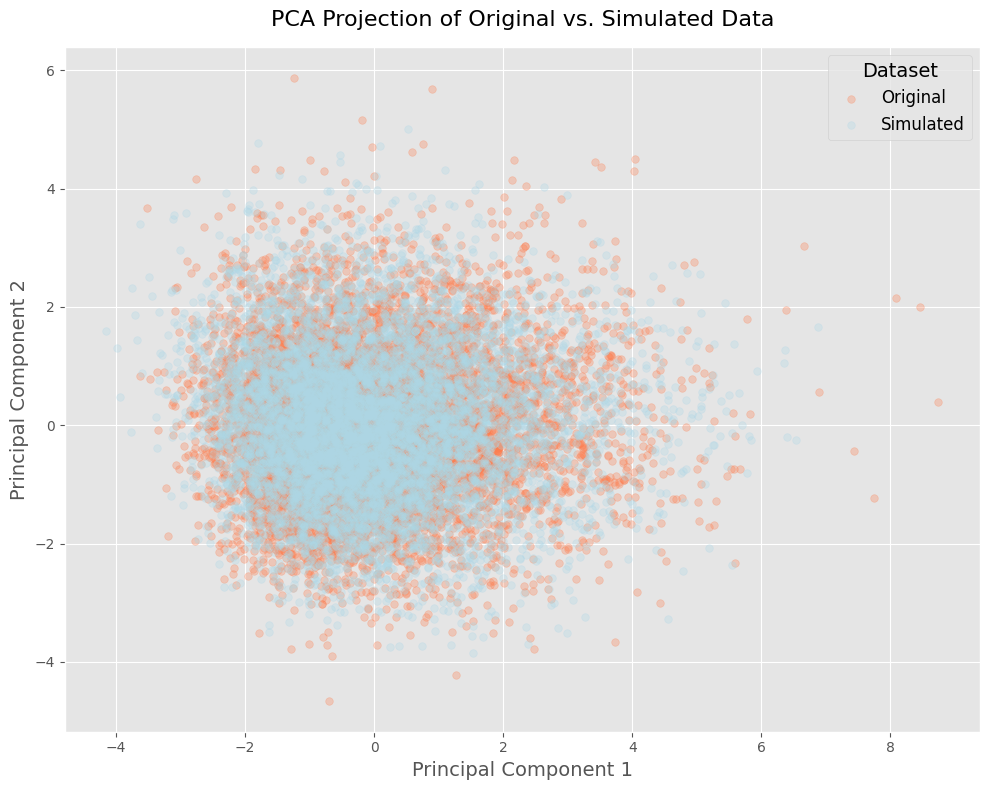

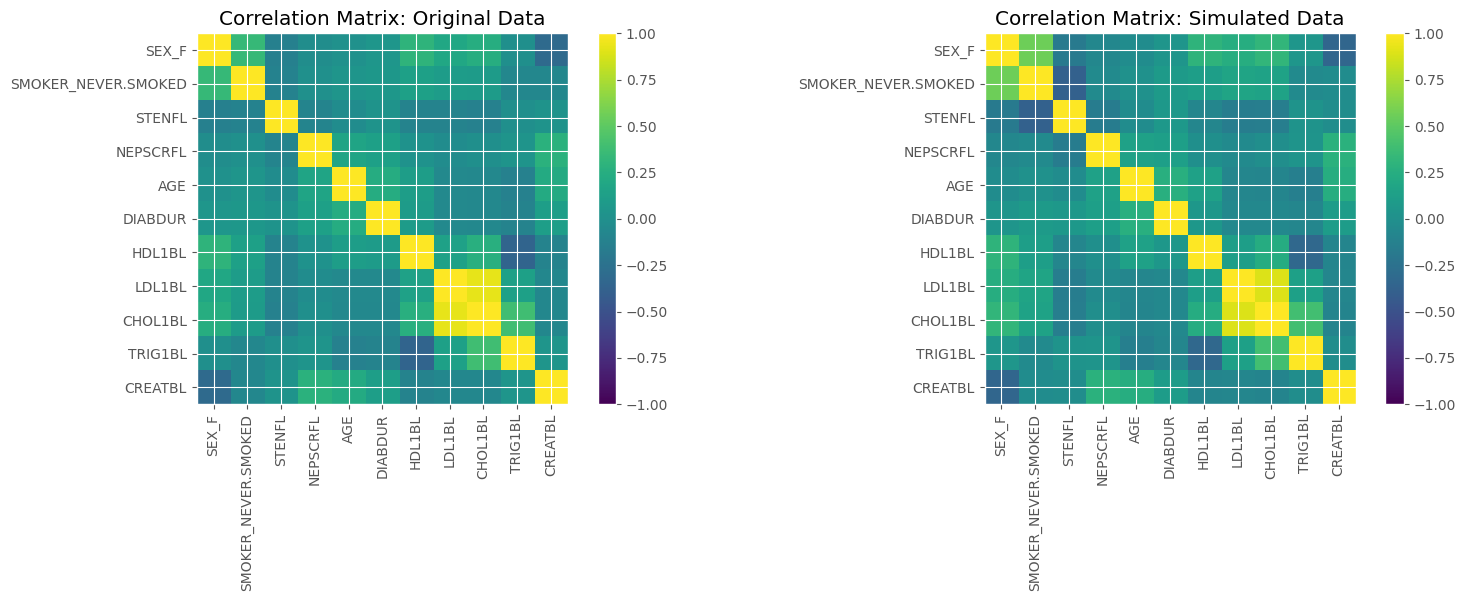

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46      2619
           1       0.47      0.50      0.49      2619

    accuracy                           0.47      5238
   macro avg       0.47      0.47      0.47      5238
weighted avg       0.47      0.47      0.47      5238

Accuracy: 0.47
ROC AUC: 0.48


In [11]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_norm)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


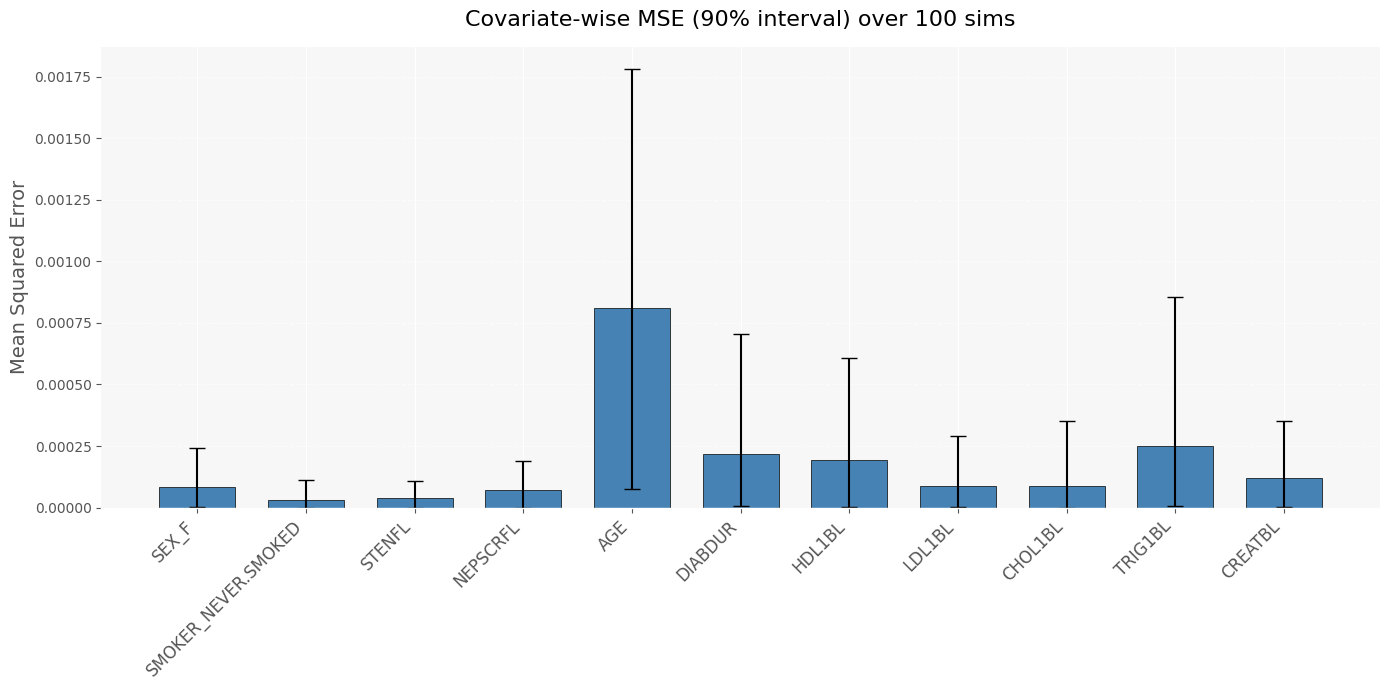

Accuracy:  μ=0.497, σ=0.008, [0.477–0.512]
AUC:       μ=0.500, σ=0.008, [0.483–0.520]


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy

# --- 1) Run your simulations, collecting **raw** squared errors --------------
num_simulations = 100
accuracy_list, auc_list = [], []
covariate_squared_errors = []

original_df = deepcopy(df_bsl_norm)
orig_cov_means = original_df.mean()
for i in range(num_simulations):
    # simulate as before...
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    simulated_df = pd.DataFrame(
        s_pred.detach().cpu().numpy(),
        columns=original_df.columns
    )
    
    # classification performance (unchanged)...
    combined = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined; y = np.concatenate([np.zeros(len(original_df)), np.ones(len(simulated_df))])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test); proba = clf.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, pred))
    auc_list.append(roc_auc_score(y_test, proba))
    
    # **raw** MSE per covariate
    sim_means = simulated_df.mean()
    raw_mse = (sim_means - orig_cov_means)**2
    covariate_squared_errors.append(raw_mse)

# Turn into DataFrame
mse_df = pd.DataFrame(covariate_squared_errors)

# --- 2) Compute mean + 5th/95th quantiles ------------------------------------
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# --- 3) Pretty bar‐plot ------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(mse_mean))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color='steelblue',
    edgecolor='black'
)

# styling
ax.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_title(f'Covariate‐wise MSE (90% interval) over {num_simulations} sims', fontsize=16, pad=15)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# ... (build combined_df with 'label' as before) ...

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred      = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc      = roc_auc_score(y_test, y_pred_proba)
report   = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC:  {auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2619
           1       0.86      0.79      0.82      2619

    accuracy                           0.83      5238
   macro avg       0.83      0.83      0.83      5238
weighted avg       0.83      0.83      0.83      5238

Accuracy: 0.83
ROC AUC:  0.91


In [19]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=50, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=20000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 43709562880.0000,	loss_y 1.6631, 1.6975, 0.0687,	loss_eta 3.1490, 3.2986, 0.2993, 	marginal_loss 43709562880.0000
Epoch 1: y_sample_mean 0.012839737348258495
Epoch 1: y_sample1_cat.float().mean() 0.5116605162620544
Epoch 1000: loss 13.2393,	loss_y 0.1589, 0.2019, 0.0860,	loss_eta 12.0173, 25.8170, 27.5996, 	marginal_loss 1.0632
Epoch 1000: y_sample_mean 0.012766843661665916
Epoch 1000: y_sample1_cat.float().mean() 0.008403581567108631
Epoch 2000: loss 12.3481,	loss_y 0.1580, 0.2231, 0.1302,	loss_eta 11.8005, 26.5489, 29.4969, 	marginal_loss 0.3896
Epoch 2000: y_sample_mean 0.012923045083880424
Epoch 2000: y_sample1_cat.float().mean() 0.012474079616367817
Epoch 3000: loss 12.1204,	loss_y 0.1539, 0.2261, 0.1444,	loss_eta 11.7803, 26.6813, 29.8020, 	marginal_loss 0.1862
Epoch 3000: y_sample_mean 0.012943871319293976
Epoch 3000: y_sample1_cat.float().mean() 0.01261359266936779
Epoch 4000: loss 12.0645,	loss_y 0.1498, 0.2313, 0.1630,	loss_eta 11.7291, 26.9316, 30.4050, 	margin

In [20]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 3.7206,	loss_y 0.1300, 0.2504, 0.2408,	loss_eta 3.4278, 8.1210, 9.3865, 	marginal_loss 0.1628
Epoch 1: y_sample_mean 0.0129334582015872
Epoch 1: y_sample1_cat.float().mean() 0.012722751125693321
Epoch 1000: loss 2.4364,	loss_y 0.1314, 0.2545, 0.2461,	loss_eta 2.2818, 5.0508, 5.5382, 	marginal_loss 0.0232
Epoch 1000: y_sample_mean 0.0129334582015872
Epoch 1000: y_sample1_cat.float().mean() 0.012965732254087925
Epoch 2000: loss 2.4381,	loss_y 0.1303, 0.2511, 0.2414,	loss_eta 2.2851, 5.0133, 5.4564, 	marginal_loss 0.0227
Epoch 2000: y_sample_mean 0.012860564514994621
Epoch 2000: y_sample1_cat.float().mean() 0.01250985637307167
Epoch 3000: loss 2.4352,	loss_y 0.1299, 0.2516, 0.2433,	loss_eta 2.2812, 5.0803, 5.5982, 	marginal_loss 0.0240
Epoch 3000: y_sample_mean 0.012881391681730747
Epoch 3000: y_sample1_cat.float().mean() 0.01260416954755783


In [21]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 5.4236, loss1 5.6532, loss2 0.4591
Epoch 1000: loss 1.5943, loss1 3.1883, loss2 3.1880
Epoch 2000: loss 1.5068, loss1 3.0219, loss2 3.0303
Epoch 3000: loss 1.4108, loss1 2.8433, loss2 2.8649
Epoch 4000: loss 1.3116, loss1 2.6298, loss2 2.6365
Epoch 5000: loss 1.2312, loss1 2.4884, loss2 2.5143
Epoch 6000: loss 1.1858, loss1 2.3729, loss2 2.3742
Epoch 7000: loss 1.1426, loss1 2.2916, loss2 2.2979
Epoch 8000: loss 1.1165, loss1 2.2307, loss2 2.2284
Epoch 9000: loss 1.0859, loss1 2.1719, loss2 2.1720
Epoch 10000: loss 1.0667, loss1 2.1373, loss2 2.1412
Epoch 11000: loss 1.0479, loss1 2.0893, loss2 2.0827
Epoch 12000: loss 1.0334, loss1 2.0696, loss2 2.0725
Epoch 13000: loss 1.0146, loss1 2.0442, loss2 2.0593
Epoch 14000: loss 1.0127, loss1 2.0188, loss2 2.0122
Epoch 15000: loss 0.9957, loss1 1.9974, loss2 2.0032
Epoch 16000: loss 0.9930, loss1 1.9801, loss2 1.9742
Epoch 17000: loss 0.9759, loss1 1.9588, loss2 1.9657
Epoch 18000: loss 0.9675, loss1 1.9402, loss2 1.9453
Epoch 

In [70]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=5e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.6133,	loss_y 0.1320, 0.2517, 0.2395,	loss_eta 2.2824, 5.1553, 5.7457, 	marginal_loss 0.1989
Epoch 1: y_sample_mean 0.012975111603736877
Epoch 1: y_sample1_cat.float().mean() 0.012418537400662899
Epoch 1000: loss 2.6104,	loss_y 0.1311, 0.2535, 0.2450,	loss_eta 2.2803, 5.1118, 5.6629, 	marginal_loss 0.1991
Epoch 1000: y_sample_mean 0.012818911112844944
Epoch 1000: y_sample1_cat.float().mean() 0.013180914334952831
Epoch 2000: loss 2.6289,	loss_y 0.1327, 0.2531, 0.2409,	loss_eta 2.2802, 5.0977, 5.6350, 	marginal_loss 0.2160
Epoch 2000: y_sample_mean 0.0129334582015872
Epoch 2000: y_sample1_cat.float().mean() 0.012671745382249355
Epoch 3000: loss 2.5862,	loss_y 0.1308, 0.2523, 0.2429,	loss_eta 2.2613, 5.0692, 5.6157, 	marginal_loss 0.1940
Epoch 3000: y_sample_mean 0.012766843661665916
Epoch 3000: y_sample1_cat.float().mean() 0.013341032899916172
Epoch 1: loss 0.8673, loss1 1.7472, loss2 1.7598
Epoch 1000: loss 0.8577, loss1 1.7359, loss2 1.7564
Epoch 2000: loss 0.8595, loss1

In [152]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=2000, lr=1e-3, print_every_iter=1000,reg_lambda=0.5)

Epoch 1: loss 2.7380,	loss_y 0.1300, 0.2490, 0.2381,	loss_eta 2.2997, 5.1002, 5.6010, 	marginal_loss 0.6165
Epoch 1: y_sample_mean 0.01303759217262268
Epoch 1: y_sample1_cat.float().mean() 0.012415497563779354
Epoch 1000: loss 2.5070,	loss_y 0.1301, 0.2552, 0.2503,	loss_eta 2.2803, 5.1007, 5.6408, 	marginal_loss 0.1933
Epoch 1000: y_sample_mean 0.013079246506094933
Epoch 1000: y_sample1_cat.float().mean() 0.012525588274002075
Epoch 2000: loss 2.5207,	loss_y 0.1287, 0.2557, 0.2541,	loss_eta 2.2938, 5.1277, 5.6677, 	marginal_loss 0.1962
Epoch 2000: y_sample_mean 0.012964698486030102
Epoch 2000: y_sample1_cat.float().mean() 0.013192636892199516


In [153]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=1e-3, print_every_iter=500,reg_lambda=0.2)

Epoch 1: loss 2.4489,	loss_y 0.1312, 0.2514, 0.2404,	loss_eta 2.2790, 5.1023, 5.6466, 	marginal_loss 0.1936
Epoch 1: y_sample_mean 0.013100072741508484
Epoch 1: y_sample1_cat.float().mean() 0.012537901289761066
Epoch 500: loss 2.4331,	loss_y 0.1310, 0.2553, 0.2486,	loss_eta 2.2632, 5.1101, 5.6939, 	marginal_loss 0.1946
Epoch 500: y_sample_mean 0.012954285368323326
Epoch 500: y_sample1_cat.float().mean() 0.012604675255715847


In [103]:

model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 0.9949, loss1 2.0262, loss2 2.0626
Epoch 1000: loss 0.8185, loss1 1.6529, loss2 1.6688
Epoch 2000: loss 0.8048, loss1 1.6329, loss2 1.6561
Epoch 3000: loss 0.7968, loss1 1.6134, loss2 1.6333
Epoch 4000: loss 0.7995, loss1 1.6180, loss2 1.6371
Epoch 5000: loss 0.7975, loss1 1.6094, loss2 1.6237
Epoch 6000: loss 0.7940, loss1 1.5947, loss2 1.6015
Epoch 7000: loss 0.7859, loss1 1.5935, loss2 1.6152
Epoch 8000: loss 0.7960, loss1 1.5969, loss2 1.6020
Epoch 9000: loss 0.7886, loss1 1.5839, loss2 1.5908
Epoch 10000: loss 0.7903, loss1 1.5907, loss2 1.6008
Epoch 11000: loss 0.7887, loss1 1.5712, loss2 1.5650
Epoch 12000: loss 0.7852, loss1 1.5738, loss2 1.5772
Epoch 13000: loss 0.7826, loss1 1.5852, loss2 1.6052
Epoch 14000: loss 0.7867, loss1 1.5793, loss2 1.5853
Epoch 15000: loss 0.7839, loss1 1.5783, loss2 1.5887
Epoch 16000: loss 0.7741, loss1 1.5698, loss2 1.5913
Epoch 17000: loss 0.7760, loss1 1.5583, loss2 1.5646
Epoch 18000: loss 0.7746, loss1 1.5587, loss2 1.5684
Epoch 

In [174]:
torch.save(model, "joint_model.pth")
print("Saved full model to joint_model.pth")


Saved full model to joint_model.pth


In [104]:
# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

In [115]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split


# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true,y_true_np], axis=1),
    columns =  s_cols+ z1_cols+ y_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 5000  
accuracy_list = []
auc_list = []


for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([ s_pred, z1_pred, y_pred], axis=1),
        columns = s_cols+ z1_cols + y_cols 
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    # ===== HERE: Random Forest instead of Logistic Regression =====
    clf_joint = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=2025,
        n_jobs=-1
    )
    clf_joint.fit(X_train, y_train)

    y_pred_lbl   = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_lbl))
    auc_list     .append(roc_auc_score(y_test, y_pred_proba))

# --- Print Summary Statistics ---
print(f"Joint Data Classification Results over {num_simulations} sims:")
print(f"Accuracy: Mean={np.mean(accuracy_list):.3f}, Std={np.std(accuracy_list,ddof=1):.3f}, "
      f"Min={np.min(accuracy_list):.3f}, Max={np.max(accuracy_list):.3f}")
print(f"AUC:      Mean={np.mean(auc_list):.3f}, Std={np.std(auc_list,ddof=1):.3f}, "
      f"Min={np.min(auc_list):.3f}, Max={np.max(auc_list):.3f}")


Joint Data Classification Results over 5000 sims:
Accuracy: Mean=0.702, Std=0.005, Min=0.682, Max=0.723
AUC:      Mean=0.794, Std=0.005, Min=0.774, Max=0.816


In [106]:
clf_joint.feature_importances_

array([3.93502889e-05, 1.09898915e-04, 1.02919952e-05, 2.17515364e-05,
       7.66840374e-03, 3.78946436e-03, 1.09746717e-03, 1.02254440e-03,
       4.74764652e-04, 1.56517398e-03, 2.68157660e-03, 1.25410284e-01,
       6.35970505e-02, 3.71215415e-02, 6.31727447e-02, 5.72189079e-02,
       1.02434974e-01, 1.47522742e-01, 7.37688258e-02, 8.15817010e-02,
       1.10216647e-01, 1.14206583e-01, 0.00000000e+00, 0.00000000e+00,
       1.08670326e-06, 0.00000000e+00, 2.28417693e-04, 6.42618483e-05,
       8.72000192e-04, 1.22947681e-03, 1.73993765e-03, 9.43939563e-04,
       1.88189988e-04])

In [142]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# --------------------------------------------------------------------
# --- Preprocessing the True (Original) Joint Data ---
# Here we assume that the function missing_impute has already been applied to your original tensors.
# x_tensor, z_tensor, y_tensor, and s_tensor are assumed to exist.
# Note: z_tensor is assumed to be of shape (n_obs, 33); it stacks z1, z2, and z3, each across 11 time points.

# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample from the baseline model to get new s (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the simulated baseline features s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply the missing imputation on simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s, y into numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape simulated z_pred to (n_obs, 11, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    # Extract the simulated z1 (all time points)
    z1_pred = z_pred_reshaped[:, :, 0]             
    # And for z2 and z3, take only the observed indices
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]
    
    # Build the simulated joint DataFrame with the same feature ordering.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    combined_joint_df= combined_joint_df.round(1)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Save the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))

Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.570, Std=0.006, Min=0.551, Max=0.587
AUC: Mean=0.595, Std=0.007, Min=0.575, Max=0.610


In [143]:
clf_joint.coef_

array([[-7.49390253e-02, -6.72533752e-03, -1.77395345e-02,
        -1.21528352e-01,  5.80288795e-02, -1.98927222e-02,
        -3.44548194e-03,  8.71543878e-02, -9.26499473e-02,
         2.09562988e-02, -4.15704275e-02,  3.79061386e-02,
         1.11146014e-01, -1.31252064e-01,  2.32049845e-01,
        -1.42484607e-02, -9.66136930e-02, -7.84063215e-02,
        -1.21465305e-01,  1.39069957e-01, -4.15724564e-02,
         8.35123465e-02,  0.00000000e+00, -6.87946808e-02,
         1.50384751e-01,  3.93899768e-02, -1.33608760e-01,
         6.09368108e-02,  3.93394797e-02,  3.00794816e-03,
        -1.69990185e+00,  1.33521166e-01,  1.74191574e+00,
         6.27246803e-02,  1.93597321e-02, -9.25116192e-06,
         8.95474199e-02, -1.88622732e-01, -1.78803194e-01,
         6.80838615e-02, -4.99439911e-01,  7.72157511e-01,
        -3.65452788e-01, -5.20855034e-02,  3.42149066e-01,
        -3.56009479e-01,  8.50544829e-02]])

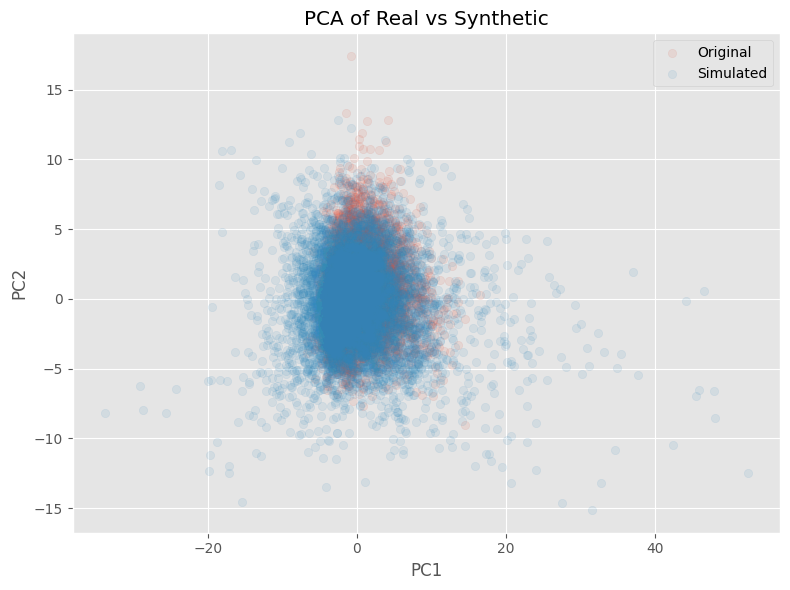

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Combine your real & one simulated dataset
combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
X = combined.drop(columns='source').values
y = combined['source'].values  # array of 'Original' / 'Simulated'

# 2) PCA → 2D
pca = PCA(n_components=2, random_state=2025)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for label in ['Original', 'Simulated']:
    idx = (y == label)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=label, alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real vs Synthetic')
plt.legend()
plt.tight_layout()
plt.show()



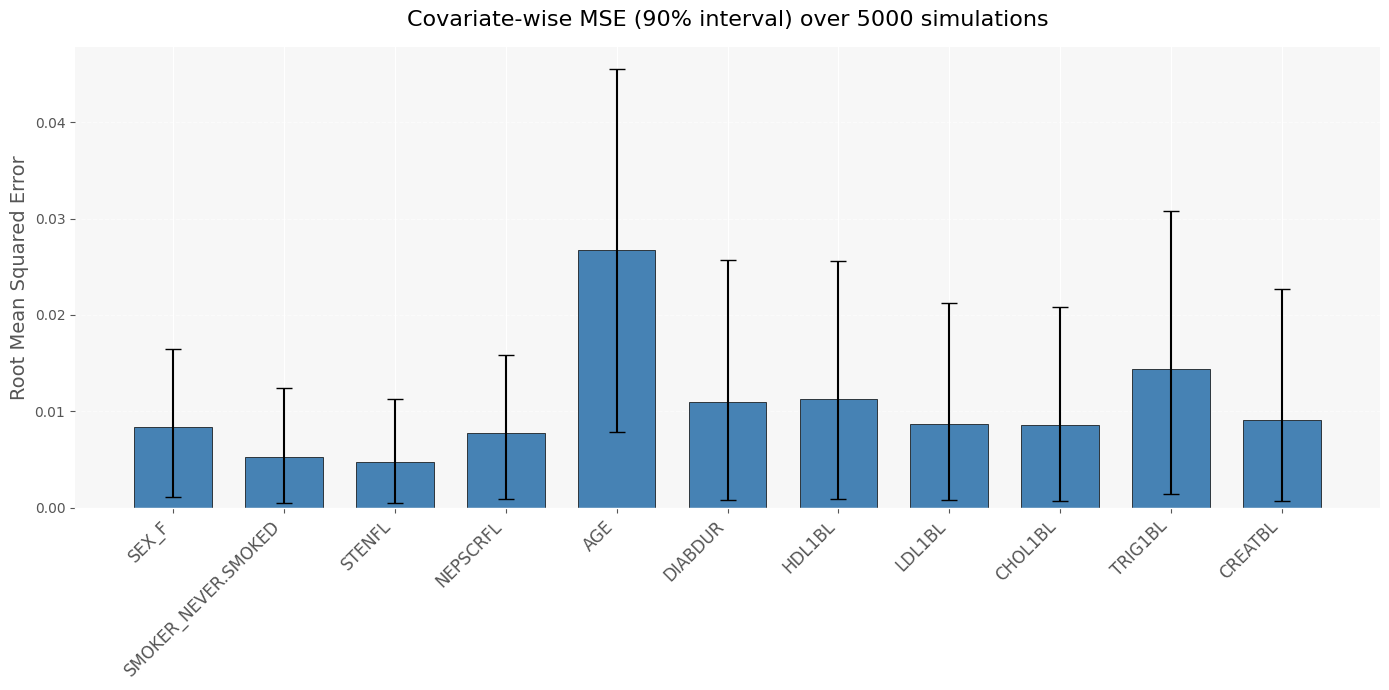

Accuracy:  μ=0.497, σ=0.008, [0.462–0.527]
AUC:       μ=0.500, σ=0.008, [0.470–0.527]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy

# --- 1) Run your simulations, collecting **raw** squared errors --------------
num_simulations = 5000
accuracy_list, auc_list = [], []
covariate_squared_errors = []

original_df = deepcopy(df_bsl_norm)
orig_cov_means = original_df.mean()
for i in range(num_simulations):
    # simulate as before...
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    simulated_df = pd.DataFrame(
        s_pred.detach().cpu().numpy(),
        columns=original_df.columns
    )
    
    # classification performance (unchanged)...
    combined = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined; y = np.concatenate([np.zeros(len(original_df)), np.ones(len(simulated_df))])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test); proba = clf.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, pred))
    auc_list.append(roc_auc_score(y_test, proba))
    
    # **raw** MSE per covariate
    sim_means = simulated_df.mean()
    raw_mse = np.sqrt((sim_means - orig_cov_means)**2)
    covariate_squared_errors.append(raw_mse)

# Turn into DataFrame
mse_df = pd.DataFrame(covariate_squared_errors)

# --- 2) Compute mean + 5th/95th quantiles ------------------------------------
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# --- 3) Pretty bar‐plot ------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(mse_mean))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color='steelblue',
    edgecolor='black'
)




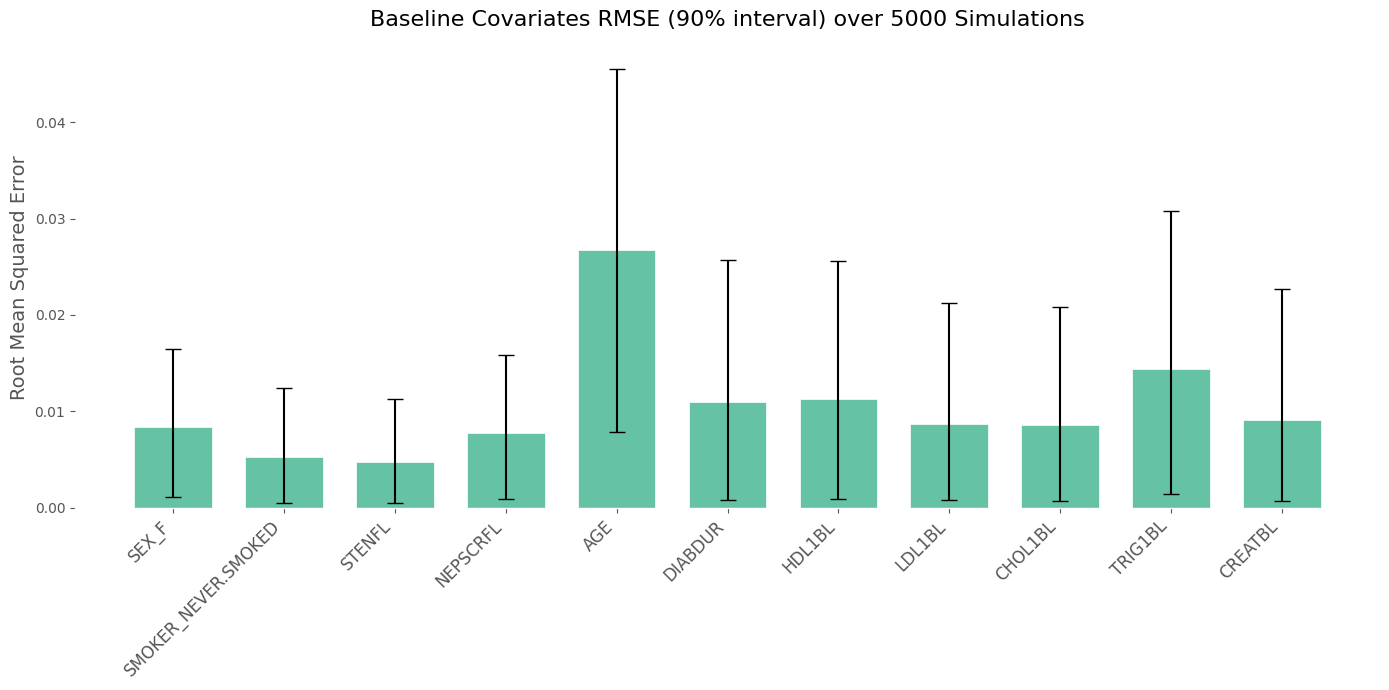

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# --- your data as before ---
# x = np.arange(len(mse_mean))
# mse_mean, yerr, num_simulations defined above

# --- pick one Set2 color ---
cmap = plt.get_cmap('Set2')
single_color = cmap(0)   # index 2 is the 3rd color in Set2

# --- plot with that color for every bar ---
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color=single_color,
    edgecolor='white'
)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=14)
ax.set_title(
    f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
    fontsize=16, pad=15
)

plt.tight_layout()
plt.show()


In [165]:
import numpy as np
from pathlib import Path

# ------------------------------------------------------------------
# 📌 SAVE  –– put this right after you finish computing rmse_stats
# ------------------------------------------------------------------
outdir = Path("results")         # wherever you like
outdir.mkdir(exist_ok=True)

np.savez(outdir / "rmse_stats.npz",
         z1_mean = rmse_stats['z1']['mean'],
         z1_std  = rmse_stats['z1']['std'],
         z2_mean = rmse_stats['z2']['mean'],
         z2_std  = rmse_stats['z2']['std'],
         z3_mean = rmse_stats['z3']['mean'],
         z3_std  = rmse_stats['z3']['std'],
         time_z1 = np.arange(timepoints),   # store the x‑tick helpers too
         time_z2 = np.arange(len(obs_idx)),
         obs_idx = np.array(obs_idx))       # keep original indices just in case
print("Saved ➜", outdir / "rmse_stats.npz")


Saved ➜ results/rmse_stats.npz


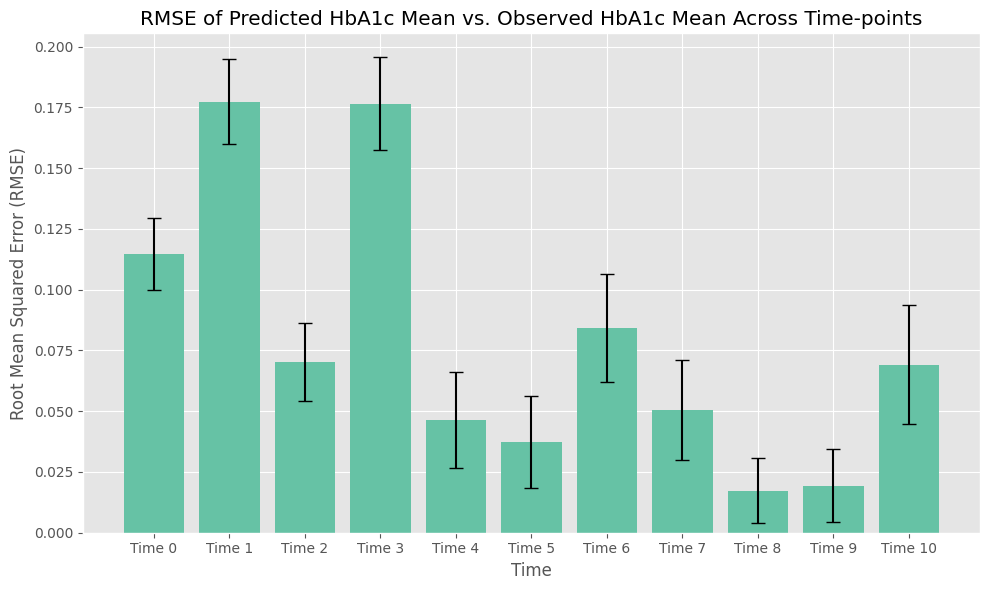

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# --- Compute ROOT MEAN SQUARE ERROR (RMSE) -----------------------------

# Squared error of the *mean* trajectory for each MC draw and time‑point
squared_errors = (z1_samples_mean - z1_obs_mean) ** 2       # shape: (num_samples, timepoints)

# Root of the squared errors → RMSE per draw and time‑point
rmse_per_sample = np.sqrt(squared_errors)                   # shape: (num_samples, timepoints)

# Aggregate across MC draws
rmse_mean = np.mean(rmse_per_sample, axis=0)                # mean RMSE at each time‑point
rmse_std  = np.std (rmse_per_sample, axis=0, ddof=1)        # SD of RMSE for error bars

# --- Plot -------------------------------------------------------------

time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, rmse_mean, yerr=rmse_std, capsize=5,
        color=sns.color_palette("Set2")[0])

plt.xlabel("Time")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE of Predicted HbA1c Mean vs. Observed HbA1c Mean Across Time‑points")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()




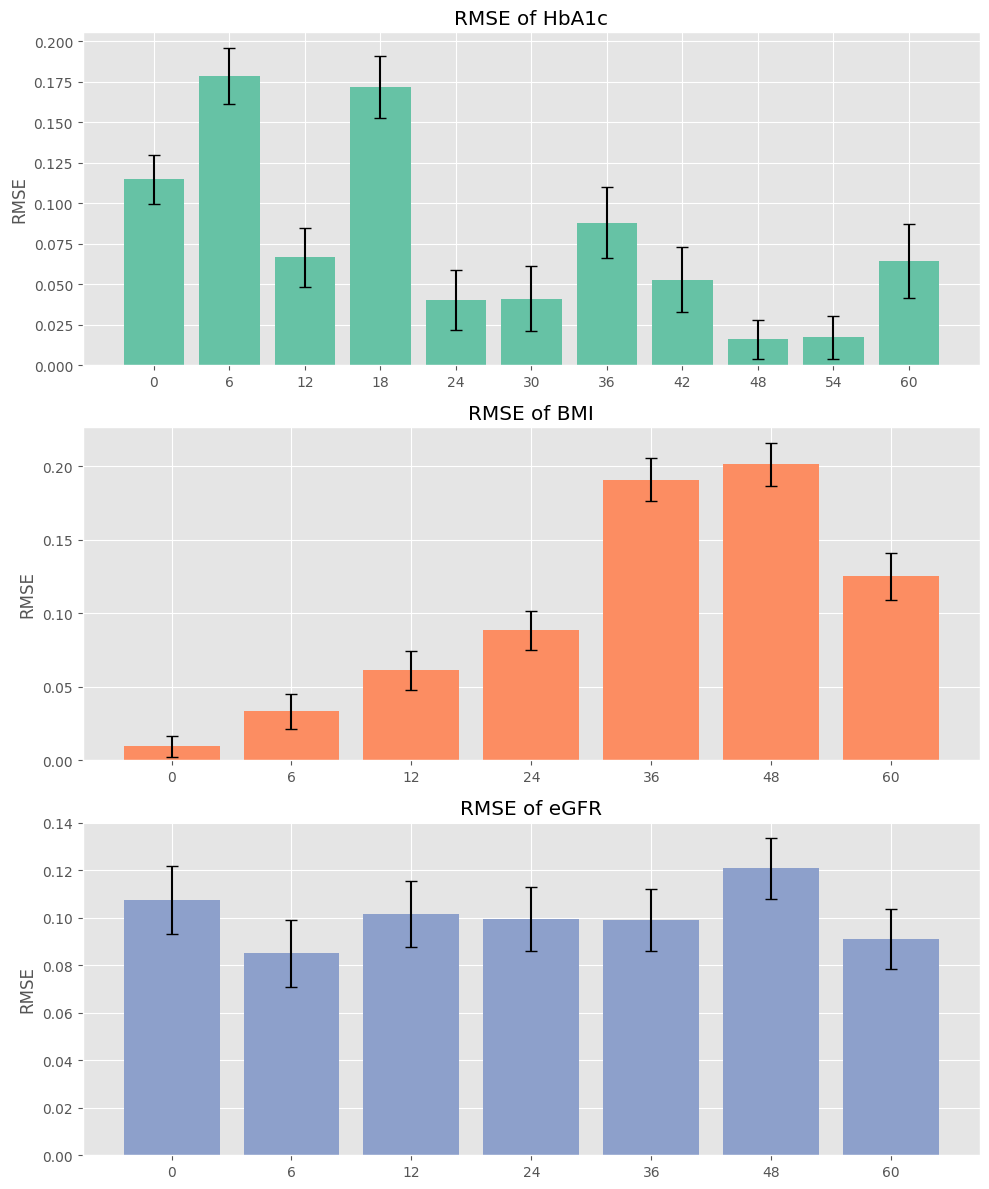

In [ ]:
num_samples   = 500                     # MC draws of the joint model
timepoints    = 11
obs_idx       = observed_idx            # [0,1,2,4,6,8,10]
n_obs, z_dim  = z_tensor.shape[0], 3

z1_samples, z2_samples, z3_samples = [], [], []

for _ in range(num_samples):
    # fresh posterior / model draw
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)


    z_pred_np  = z_pred.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()

    z1_samples.append(z_pred_np[:, :, 0])        # (n_obs, 11)
    z2_samples.append(z_pred_np[:, obs_idx, 1])  # (n_obs, 7)
    z3_samples.append(z_pred_np[:, obs_idx, 2])  # (n_obs, 7)

# → arrays with shape (num_samples, n_obs, ...)
z1_samples = np.stack(z1_samples, axis=0)
z2_samples = np.stack(z2_samples, axis=0)
z3_samples = np.stack(z3_samples, axis=0)

# --------------------------------------------------------------------
# 2.  OBSERVED (GROUND‑TRUTH) STATISTICS  -----------------------------
z_true_np     = z_tensor.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()
z1_obs_mean   = z_true_np[:, :, 0].mean(axis=0)         # (11,)
z2_obs_mean   = z_true_np[:, obs_idx, 1].mean(axis=0)   # (7,)
z3_obs_mean   = z_true_np[:, obs_idx, 2].mean(axis=0)   # (7,)

# --------------------------------------------------------------------
# 3.  RMSE PER MC‑DRAW & TIME‑POINT  ---------------------------------
def rmse_per_sample(z_samples, z_mean_obs):
    """Return array (num_samples, T) with RMSE for each MC draw."""
    # squared error of the biomarker *mean* trajectory
    sq_err = (z_samples.mean(axis=1) - z_mean_obs[np.newaxis, :]) ** 2
    return np.sqrt(sq_err)

rmse_z1 = rmse_per_sample(z1_samples, z1_obs_mean)  # (num_samples, 11)
rmse_z2 = rmse_per_sample(z2_samples, z2_obs_mean)  # (num_samples, 7)
rmse_z3 = rmse_per_sample(z3_samples, z3_obs_mean)  # (num_samples, 7)

# aggregate across MC draws
rmse_stats = {
    'z1': {'mean': rmse_z1.mean(axis=0), 'std': rmse_z1.std(axis=0, ddof=1)},
    'z2': {'mean': rmse_z2.mean(axis=0), 'std': rmse_z2.std(axis=0, ddof=1)},
    'z3': {'mean': rmse_z3.mean(axis=0), 'std': rmse_z3.std(axis=0, ddof=1)},
}

# --------------------------------------------------------------------
# 4.  PLOT  -----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)

# --- z1 (11 visits) ---
time_z1 = np.arange(timepoints)
axes[0].bar(time_z1,
            rmse_stats['z1']['mean'],
            yerr=rmse_stats['z1']['std'],
            capsize=4, color=palette[0])
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE of HbA1c")
axes[0].set_xticks(time_z1, [f"{t}" for t in time_points])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# --- z2 (observed visits) ---
time_z2 = np.arange(len(obs_idx))
axes[1].bar(time_z2,
            rmse_stats['z2']['mean'],
            yerr=rmse_stats['z2']['std'],
            capsize=4, color=palette[1])
axes[1].set_ylabel("RMSE")
axes[1].set_title("RMSE of BMI")
axes[1].set_xticks(time_z2, [f"{time_points[i]}" for i in obs_idx])

# --- z3 (observed visits) ---
time_z3 = np.arange(len(obs_idx))
axes[2].bar(time_z3,
            rmse_stats['z3']['mean'],
            yerr=rmse_stats['z3']['std'],
            capsize=4, color=palette[2])
axes[2].set_ylabel("RMSE")
axes[2].set_title("RMSE of eGFR")
axes[2].set_xticks(time_z3, [f"{time_points[i]}" for i in obs_idx])
axes[2].set_xlabel("Time (months)")    

plt.tight_layout()
plt.show()


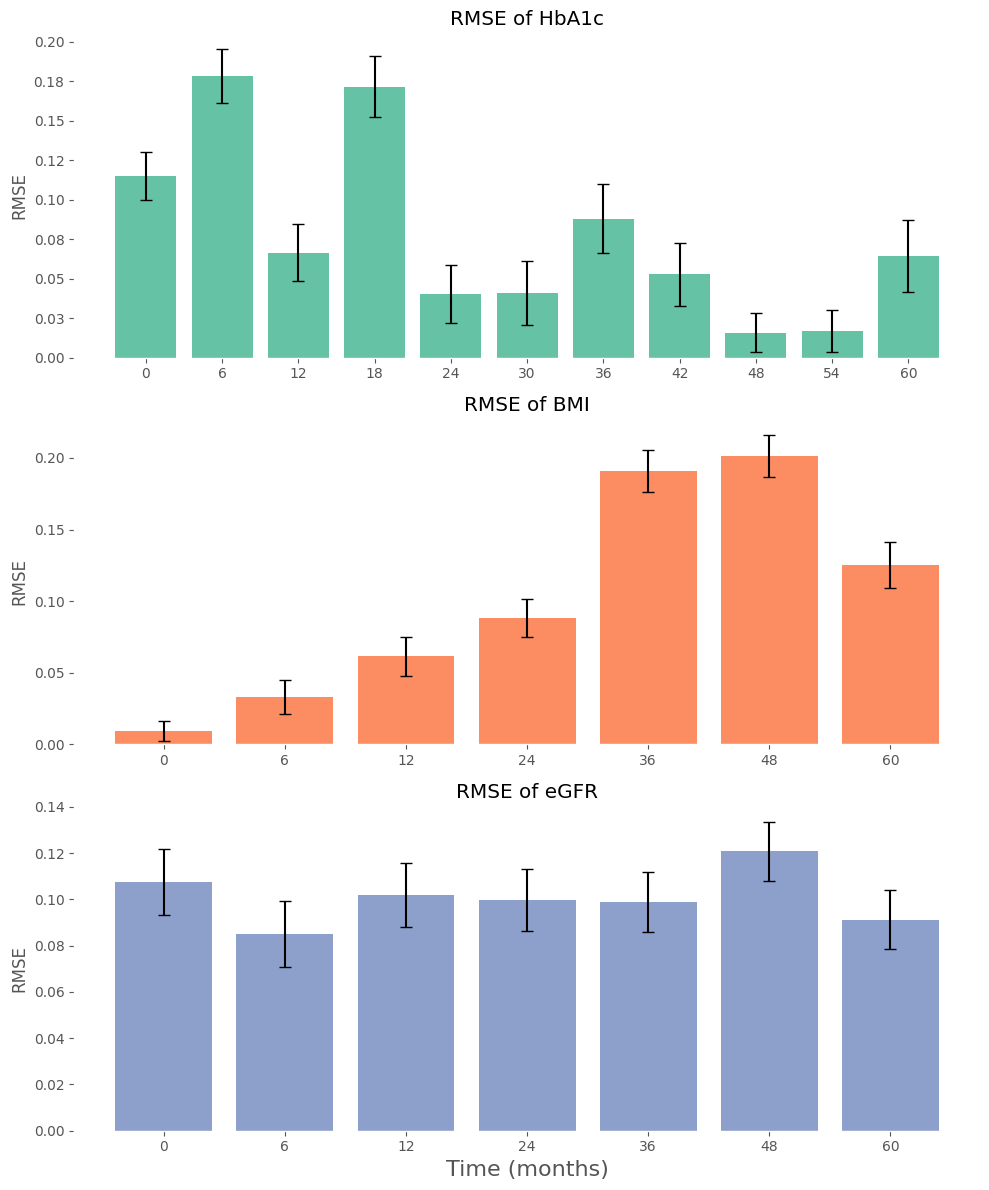

In [173]:
from matplotlib.ticker import FormatStrFormatter   # ✨ new
# → arrays with shape (num_samples, n_obs, ...)
z1_samples = np.stack(z1_samples, axis=0)
z2_samples = np.stack(z2_samples, axis=0)
z3_samples = np.stack(z3_samples, axis=0)

# --------------------------------------------------------------------
# 2.  OBSERVED (GROUND‑TRUTH) STATISTICS  -----------------------------
z_true_np     = z_tensor.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()
z1_obs_mean   = z_true_np[:, :, 0].mean(axis=0)         # (11,)
z2_obs_mean   = z_true_np[:, obs_idx, 1].mean(axis=0)   # (7,)
z3_obs_mean   = z_true_np[:, obs_idx, 2].mean(axis=0)   # (7,)

# --------------------------------------------------------------------
# 3.  RMSE PER MC‑DRAW & TIME‑POINT  ---------------------------------
def rmse_per_sample(z_samples, z_mean_obs):
    """Return array (num_samples, T) with RMSE for each MC draw."""
    # squared error of the biomarker *mean* trajectory
    sq_err = (z_samples.mean(axis=1) - z_mean_obs[np.newaxis, :]) ** 2
    return np.sqrt(sq_err)

rmse_z1 = rmse_per_sample(z1_samples, z1_obs_mean)  # (num_samples, 11)
rmse_z2 = rmse_per_sample(z2_samples, z2_obs_mean)  # (num_samples, 7)
rmse_z3 = rmse_per_sample(z3_samples, z3_obs_mean)  # (num_samples, 7)

# aggregate across MC draws
rmse_stats = {
    'z1': {'mean': rmse_z1.mean(axis=0), 'std': rmse_z1.std(axis=0, ddof=1)},
    'z2': {'mean': rmse_z2.mean(axis=0), 'std': rmse_z2.std(axis=0, ddof=1)},
    'z3': {'mean': rmse_z3.mean(axis=0), 'std': rmse_z3.std(axis=0, ddof=1)},
}

# --------------------------------------------------------------------
# 4.  PLOT  -----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')
# --- z1 (11 visits) ---
time_z1 = np.arange(timepoints)
axes[0].bar(time_z1,
            rmse_stats['z1']['mean'],
            yerr=rmse_stats['z1']['std'],
            capsize=4, color=palette[0])
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE of HbA1c")
axes[0].set_xticks(time_z1, [f"{t}" for t in time_points])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# --- z2 (observed visits) ---
time_z2 = np.arange(len(obs_idx))
axes[1].bar(time_z2,
            rmse_stats['z2']['mean'],
            yerr=rmse_stats['z2']['std'],
            capsize=4, color=palette[1])
axes[1].set_ylabel("RMSE")
axes[1].set_title("RMSE of BMI")
axes[1].set_xticks(time_z2, [f"{time_points[i]}" for i in obs_idx])

# --- z3 (observed visits) ---
time_z3 = np.arange(len(obs_idx))
axes[2].bar(time_z3,
            rmse_stats['z3']['mean'],
            yerr=rmse_stats['z3']['std'],
            capsize=4, color=palette[2])
axes[2].set_ylabel("RMSE")
axes[2].set_title("RMSE of eGFR")
axes[2].set_xticks(time_z3, [f"{time_points[i]}" for i in obs_idx])
axes[2].set_xlabel("Time (months)", fontsize=16)    

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# --- Compute ROOT MEAN SQUARE ERROR (RMSE) -----------------------------

# Squared error of the *mean* trajectory for each MC draw and time‑point
squared_errors = (z1_samples_mean - z1_obs_mean) ** 2       # shape: (num_samples, timepoints)

# Root of the squared errors → RMSE per draw and time‑point
rmse_per_sample = np.sqrt(squared_errors)                   # shape: (num_samples, timepoints)

# Aggregate across MC draws
rmse_mean = np.mean(rmse_per_sample, axis=0)                # mean RMSE at each time‑point
rmse_std  = np.std (rmse_per_sample, axis=0, ddof=1)        # SD of RMSE for error bars

# --- Plot -------------------------------------------------------------

time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, rmse_mean, yerr=rmse_std, capsize=5,
        color=sns.color_palette("Set2")[0])

plt.xlabel("Time")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE of Predicted HbA1c Mean vs. Observed HbA1c Mean Across Time‑points")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()




In [154]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 5000
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)
N0, T = s_tensor[(x_tensor[:,0]==0),:].shape
N1, T = s_tensor[(x_tensor[:,0]==1),:].shape
# Prepare “pure” control/treatment arms
x_control = torch.zeros((N0, T), dtype=torch.int32)
x_treat   = torch.ones((N1, T), dtype=torch.int32)

control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [155]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.05), np.quantile(control_event_rates,0.95)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.05),   np.quantile(treat_event_rates, 0.95)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 5000 sims: 0.132–0.149
 Treatment arm event‐rate over 5000 sims: 0.119–0.136
0.14042013755440713
0.12737372990101575


In [146]:
y_ctrl_true = y_tensor[(x_tensor[:,0]==0),:]
y_trt_true = y_tensor[(x_tensor[:,1]==0),:]

ever_ctrl_true = (y_ctrl_true.sum(dim=1) > 0).float()

In [147]:
mask = (arm_values == 1)
y_tr = y_tensor[mask,:]
y_cr = y_tensor[~mask,:]
sum(y_tr==1).sum()/y_tr.shape[0]

tensor(0.1263)

In [148]:
sum(y_cr==1).sum()/y_cr.shape[0]

tensor(0.1413)